In [ ]:
!wget -nc https://storage.googleapis.com/mathwriting_data/mathwriting-2024.tgz

!tar zxf mathwriting-2024.tgz
!ls mathwriting-2024

!rm -rf mathwriting-2024.tgz

--2025-07-16 20:56:59--  https://storage.googleapis.com/mathwriting_data/mathwriting-2024.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.207, 142.251.167.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3096141721 (2.9G) [application/gzip]
Saving to: ‘mathwriting-2024.tgz’

mathwriting-2024.tg 100%[===================>]   2.88G   133MB/s    in 28s     

2025-07-16 20:57:27 (104 MB/s) - ‘mathwriting-2024.tgz’ saved [3096141721/3096141721]

readme.md  symbols.jsonl  synthetic-bboxes.jsonl  train
symbols    synthetic	  test			  valid


In [ ]:
MATHWRITING_ROOT_DIR='mathwriting-2024'

In [ ]:
import dataclasses
import json
import os
import pprint
import re

import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as mpl_patches

from xml.etree import ElementTree

In [ ]:
@dataclasses.dataclass
class Ink:
  """Represents a single ink, as read from an InkML file."""
  # Every stroke in the ink.
  # Each stroke array has shape (3, number of points), where the first
  # dimensions are (x, y, timestamp), in that order.
  strokes: list[np.ndarray]
  # Metadata present in the InkML.
  annotations: dict[str, str]


def read_inkml_file(filename: str) -> Ink:
  """Simple reader for MathWriting's InkML files."""
  with open(filename, "r") as f:
    root = ElementTree.fromstring(f.read())

  strokes = []
  annotations = {}

  for element in root:
    tag_name = element.tag.removeprefix('{http://www.w3.org/2003/InkML}')
    if tag_name == 'annotation':
      annotations[element.attrib.get('type')] = element.text

    elif tag_name == 'trace':
      points = element.text.split(',')
      stroke_x, stroke_y, stroke_t = [], [], []
      for point in points:
        x, y, t = point.split(' ')
        stroke_x.append(float(x))
        stroke_y.append(float(y))
        stroke_t.append(float(t))
      strokes.append(np.array((stroke_x, stroke_y, stroke_t)))

  return Ink(strokes=strokes, annotations=annotations)


def display_ink(
    ink: Ink,
    *,
    figsize: tuple[int, int]=(15, 10),
    linewidth: int=2,
    color=None):
  """Simple display for a single ink."""
  pl.figure(figsize=figsize)
  for stroke in ink.strokes:
    pl.plot(stroke[0], stroke[1], linewidth=linewidth, color=color)
    pl.title(
        f"{ink.annotations.get('sampleId', '')} -- "
        f"{ink.annotations.get('splitTagOriginal', '')} -- "
        f"{ink.annotations.get('normalizedLabel', ink.annotations['label'])}"
    )
  pl.gca().invert_yaxis()
  pl.gca().axis('equal')

{'inkCreationMethod': 'human',
 'label': '\\bigoplus',
 'sampleId': '0005e477f85ab99f',
 'splitTagOriginal': 'symbols'}


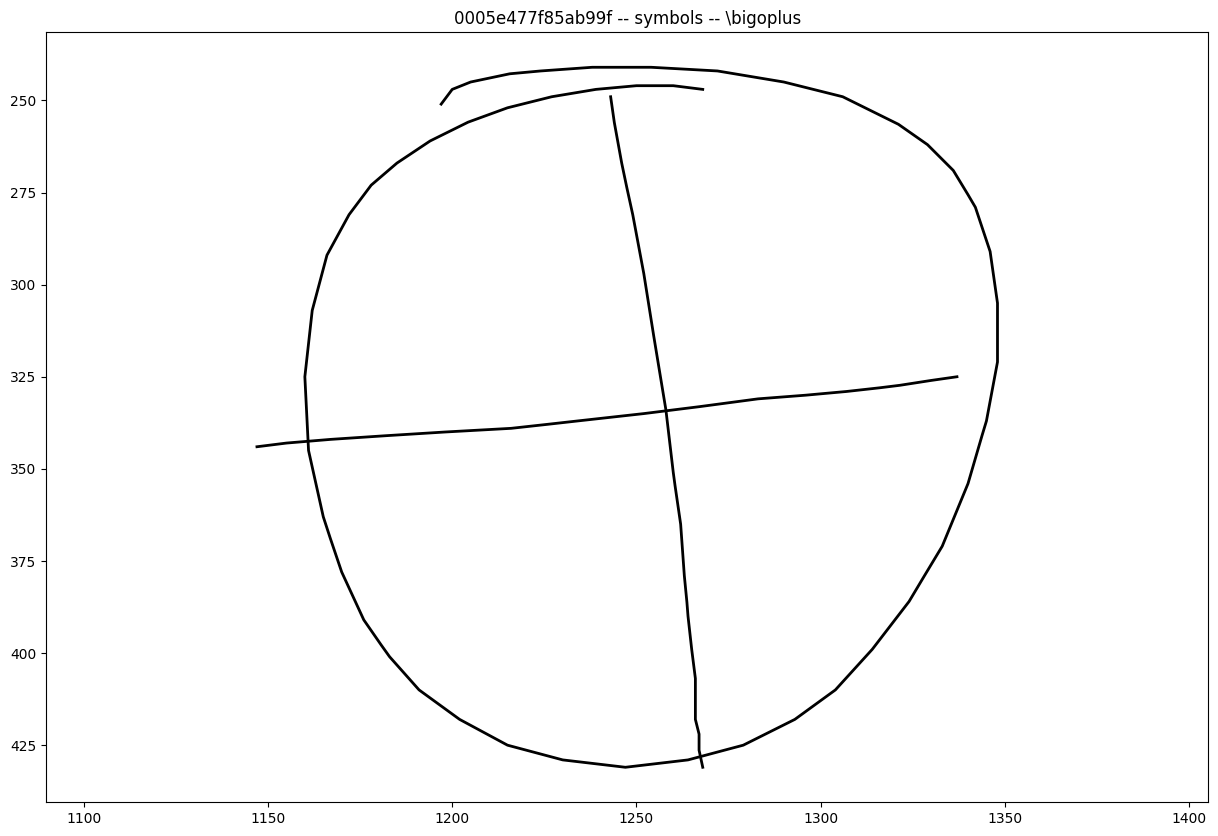

In [ ]:
ink = read_inkml_file(os.path.join(MATHWRITING_ROOT_DIR, 'symbols', '0005e477f85ab99f.inkml'))
pprint.pprint(ink.annotations)
display_ink(ink, color='black')

In [ ]:

@dataclasses.dataclass
class BoundingBox:
  """A bounding box for a single symbol."""
  # The symbol that should appear in the bounding box, in LaTeX notation.
  token: str
  # Definition of the bounding box.
  x_min: float
  y_min: float
  x_max: float
  y_max: float


@dataclasses.dataclass
class BoundingBoxes:
  """A set of bounding boxes for a complete mathematical expression."""
  # The complete (raw) LaTeX string.
  label: str
  # A normalized version of `label`.
  normalized_label: str|None
  # Bounding boxes for all symbols in the expression, in no particular order.
  bboxes: list[BoundingBox]


def read_bbox_file(filename: str, *, index: int=0) -> BoundingBoxes:
  """Reads a single bounding box from the input file."""
  with open(filename, "r") as f:
    for n, line in enumerate(f):
      if n < index:
        continue

      bboxes = json.loads(line)

      symbol_bboxes = []
      for bbox in bboxes['bboxes']:
        symbol_bboxes.append(BoundingBox(
            token=bbox['token'],
            x_min=bbox['xMin'],
            y_min=bbox['yMin'],
            x_max=bbox['xMax'],
            y_max=bbox['yMax']))

      return BoundingBoxes(
              label=bboxes['label'],
              normalized_label=bboxes.get('normalizedLabel', None),
              bboxes = symbol_bboxes)


def display_bboxes(bboxes: BoundingBoxes, *, figsize: tuple[int, int]=(15, 10)):
  """Displays a set of bounding boxes for debugging purposes."""
  fig = pl.figure(figsize=figsize)
  ax = fig.gca()
  x_min = float('inf')
  y_min = float('inf')
  x_max = -float('inf')
  y_max = -float('inf')
  for bbox in bboxes.bboxes:
    x_min = min(x_min, bbox.x_min)
    y_min = min(y_min, bbox.y_min)
    x_max = max(x_max, bbox.x_max)
    y_max = max(y_max, bbox.y_max)

    ax.add_patch(
        mpl_patches.Polygon(
            ((bbox.x_min,bbox.y_min),
            (bbox.x_min,bbox.y_max),
            (bbox.x_max,bbox.y_max),
            (bbox.x_max, bbox.y_min)),
            closed=True,
            facecolor='none',
            edgecolor='darkblue',
            linewidth=2))

  width = x_max - x_min
  height = y_max - y_min

  # We put the text in one go at the end to be able to scale it properly.
  for bbox in bboxes.bboxes:
    box_width = bbox.x_max - bbox.x_min
    box_height = bbox.y_max - bbox.y_min
    if bbox.token != r'\frac':
      ax.text(bbox.x_min+box_width/2,
              bbox.y_min+box_height/2,
              bbox.token,
              verticalalignment='center',
              horizontalalignment='center',
              fontsize=100000 / max(width, height))

  margin_ratio = 0.1
  ax.set_xlim(x_min-margin_ratio*width, x_max+margin_ratio*width)
  ax.set_ylim(y_max+margin_ratio*height, y_min-margin_ratio*height)
  pl.title(bboxes.normalized_label or bboxes.label)

In [ ]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
libjpeg-dev is already the newest version (8c-2ubuntu10).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.9-2ubuntu0.1).
libgif-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import cairo
import math
import PIL
import PIL.Image


def cairo_to_pil(surface: cairo.ImageSurface) -> PIL.Image.Image:
  """Converts a ARGB Cairo surface into an RGB PIL image."""
  size = (surface.get_width(), surface.get_height())
  stride = surface.get_stride()
  with surface.get_data() as memory:
    return PIL.Image.frombuffer(
        'RGB', size, memory.tobytes(), 'raw', 'BGRX', stride
    )


def render_ink(
    ink: Ink,
    *,
    margin: int = 10,
    stroke_width: float = 1.5,
    stroke_color: tuple[float, float, float] = (0.0, 0.0, 0.0),
    background_color: tuple[float, float, float] = (1.0, 1.0, 1.0),
) -> PIL.Image.Image:
  """Renders an ink as a PIL image using Cairo.

  The image size is chosen to fit the entire ink while having one pixel per
  InkML unit.

  Args:
    margin: size of the blank margin around the image (pixels)
    stroke_width: width of each stroke (pixels)
    stroke_color: color to paint the strokes with
    background_color: color to fill the background with

  Returns:
    Rendered ink, as a PIL image.
  """

  # Compute transformation to fit the ink in the image.
  xmin, ymin = np.vstack([stroke[:2].min(axis=1) for stroke in ink.strokes]).min(axis=0)
  xmax, ymax = np.vstack([stroke[:2].max(axis=1) for stroke in ink.strokes]).max(axis=0)
  width = int(xmax - xmin + 2*margin)
  height = int(ymax - ymin + 2*margin)

  shift_x = - xmin + margin
  shift_y = - ymin + margin

  def apply_transform(ink_x: float, ink_y: float):
    return ink_x + shift_x, ink_y + shift_y

  # Create the canvas with the background color
  surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
  ctx = cairo.Context(surface)
  ctx.set_source_rgb(*background_color)
  ctx.paint()

  # Set pen parameters
  ctx.set_source_rgb(*stroke_color)
  ctx.set_line_width(stroke_width)
  ctx.set_line_cap(cairo.LineCap.ROUND)
  ctx.set_line_join(cairo.LineJoin.ROUND)

  for stroke in ink.strokes:
    if len(stroke[0]) == 1:
      # For isolated points we just draw a filled disk with a diameter equal
      # to the line width.
      x, y = apply_transform(stroke[0, 0], stroke[1, 0])
      ctx.arc(x, y, stroke_width / 2, 0, 2 * math.pi)
      ctx.fill()

    else:
      ctx.move_to(*apply_transform(stroke[0,0], stroke[1,0]))

      for ink_x, ink_y in stroke[:2, 1:].T:
        ctx.line_to(*apply_transform(ink_x, ink_y))
      ctx.stroke()

  return cairo_to_pil(surface)

ink = read_inkml_file(os.path.join(MATHWRITING_ROOT_DIR, 'train', '00002504391b73b5.inkml'))

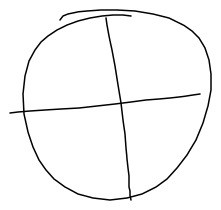

In [ ]:
ink = read_inkml_file(os.path.join(MATHWRITING_ROOT_DIR, 'symbols', '0005e477f85ab99f.inkml'))
render_ink(ink)

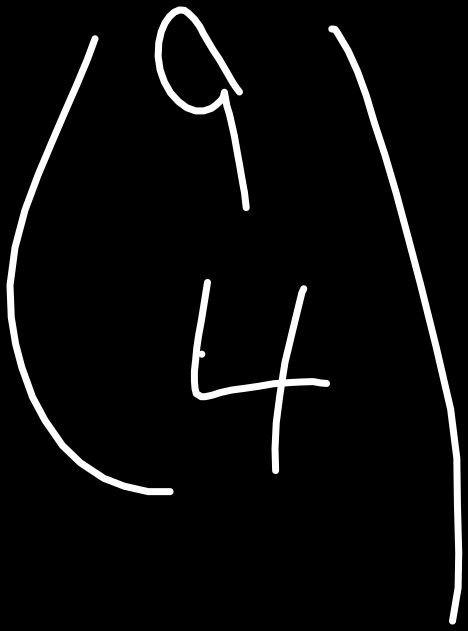

In [ ]:
render_ink(
    ink,
    stroke_width=7.0,
    stroke_color=(1, 1, 1),
    background_color=(0, 0, 0),
  )

In [ ]:
!wget -nc https://storage.googleapis.com/mathwriting_data/mathwriting-2024-excerpt.tgz
!tar zxf mathwriting-2024-excerpt.tgz
!ls mathwriting-2024-excerpt


--2025-07-16 20:07:21--  https://storage.googleapis.com/mathwriting_data/mathwriting-2024-excerpt.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1620634 (1.5M) [application/gzip]
Saving to: ‘mathwriting-2024-excerpt.tgz’

mathwriting-2024-ex 100%[===================>]   1.54M  --.-KB/s    in 0.02s   

2025-07-16 20:07:21 (88.8 MB/s) - ‘mathwriting-2024-excerpt.tgz’ saved [1620634/1620634]

readme.md  symbols.jsonl  synthetic-bboxes.jsonl  train
symbols    synthetic	  test			  valid


In [ ]:
import os
import json
import numpy as np
import dataclasses
from xml.etree import ElementTree
import cairo
import math
import PIL
import PIL.Image
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# NOTE: The dataclasses and functions from the previous response are included below.
#
# @dataclasses.dataclass
# class Ink: ...
#
# def read_inkml_file(filename: str) -> Ink: ...
#
# def render_ink(...) -> PIL.Image.Image: ...
#

@dataclasses.dataclass
class Ink:
  """Represents a single ink, as read from an InkML file."""
  strokes: list[np.ndarray]
  annotations: dict[str, str]


def read_inkml_file(filename: str) -> Ink:
  """Simple reader for MathWriting's InkML files."""
  with open(filename, "r") as f:
    root = ElementTree.fromstring(f.read())

  strokes = []
  annotations = {}

  for element in root:
    tag_name = element.tag.removeprefix('{http://www.w3.org/2003/InkML}')
    if tag_name == 'annotation':
      annotations[element.attrib.get('type')] = element.text

    elif tag_name == 'trace':
      points = element.text.strip().split(',')
      stroke_x, stroke_y, stroke_t = [], [], []
      for point in points:
        parts = point.strip().split(' ')
        if len(parts) == 3:
            x, y, t = parts
            stroke_x.append(float(x))
            stroke_y.append(float(y))
            stroke_t.append(float(t))
      if stroke_x:
        strokes.append(np.array((stroke_x, stroke_y, stroke_t)))

  return Ink(strokes=strokes, annotations=annotations)


def cairo_to_pil(surface: cairo.ImageSurface) -> PIL.Image.Image:
  """Converts a ARGB Cairo surface into an RGB PIL image."""
  size = (surface.get_width(), surface.get_height())
  stride = surface.get_stride()
  with surface.get_data() as memory:
    return PIL.Image.frombuffer(
        'RGB', size, memory.tobytes(), 'raw', 'BGRX', stride
    )

def render_ink(
    ink: Ink,
    *,
    margin: int = 10,
    stroke_width: float = 1.5,
    stroke_color: tuple[float, float, float] = (1.0, 1.0, 1.0),
    background_color: tuple[float, float, float] = (0.0, 0.0, 0.0),
) -> PIL.Image.Image:
  """Renders an ink as a PIL image using Cairo."""
  if not ink.strokes:
      return PIL.Image.new('RGB', (2 * margin, 2 * margin), (int(c * 255) for c in background_color))

  xmin, ymin = np.vstack([stroke[:2].min(axis=1) for stroke in ink.strokes]).min(axis=0)
  xmax, ymax = np.vstack([stroke[:2].max(axis=1) for stroke in ink.strokes]).max(axis=0)
  width = int(xmax - xmin + 2*margin)
  height = int(ymax - ymin + 2*margin)

  shift_x = -xmin + margin
  shift_y = -ymin + margin

  def apply_transform(ink_x: float, ink_y: float):
    return ink_x + shift_x, ink_y + shift_y

  surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
  ctx = cairo.Context(surface)
  ctx.set_source_rgb(*background_color)
  ctx.paint()

  ctx.set_source_rgb(*stroke_color)
  ctx.set_line_width(stroke_width)
  ctx.set_line_cap(cairo.LineCap.ROUND)
  ctx.set_line_join(cairo.LineJoin.ROUND)

  for stroke in ink.strokes:
    if not stroke.size:
        continue
    if len(stroke[0]) == 1:
      x, y = apply_transform(stroke[0, 0], stroke[1, 0])
      ctx.arc(x, y, stroke_width / 2, 0, 2 * math.pi)
      ctx.fill()
    else:
      ctx.move_to(*apply_transform(stroke[0,0], stroke[1,0]))
      for ink_x, ink_y in stroke[:2, 1:].T:
        ctx.line_to(*apply_transform(ink_x, ink_y))
      ctx.stroke()

  return cairo_to_pil(surface)


def process_file(args):
    """
    Helper function to process a single inkml file.
    Reads an inkml file, renders it as an image, processes the label,
    and returns the image path and processed label.
    """
    input_file_path, output_dir = args
    try:
        ink = read_inkml_file(input_file_path)

        image = render_ink(
            ink,
            stroke_width=7.0,
            stroke_color=(0, 0, 0),
            background_color=(1, 1, 1),
        )

        base_filename = os.path.basename(input_file_path).replace('.inkml', '.png')
        output_image_path = os.path.join(output_dir, base_filename)
        image.save(output_image_path)

        label = ink.annotations.get('normalizedLabel', ink.annotations.get('label'))
        if label is None:
            return None

        # ================================================================= #
        # ==== CHANGE: Process the label to replace double backslashes ==== #
        processed_label = label.replace('\\\\', '\\')
        # ================================================================= #

        return {"image_path": output_image_path, "label": processed_label}
    except Exception as e:
        print(f"Could not process file {input_file_path}: {e}")
        return None

def create_dataset(mathwriting_root_dir, output_root_dir):
    """
    Converts all inkml files in train, test, and valid directories to images
    and creates a corresponding JSON file with processed labels for each dataset.
    """
    splits = ['train', 'test', 'valid']
    os.makedirs(output_root_dir, exist_ok=True)

    for split in splits:
        input_dir = os.path.join(mathwriting_root_dir, split)
        output_dir = os.path.join(output_root_dir, split)
        os.makedirs(output_dir, exist_ok=True)

        files_to_process = [
            (os.path.join(input_dir, f), output_dir)
            for f in os.listdir(input_dir) if f.endswith('.inkml')
        ]

        labels_data = []
        with ProcessPoolExecutor() as executor:
            # Wrap the executor.map with tqdm for a progress bar
            results = tqdm(
                executor.map(process_file, files_to_process),
                total=len(files_to_process),
                desc=f"Processing {split} files"
            )
            for result in results:
                if result:
                    labels_data.append(result)

        with open(os.path.join(output_root_dir, f'{split}_labels.json'), 'w') as f:
            json.dump(labels_data, f, indent=4)

        print(f"Finished processing the {split} dataset.")

In [ ]:

# Set the root directory of your MathWriting dataset
MATHWRITING_ROOT_DIR = 'mathwriting-2024'
# Set the directory where you want to save the rendered images and labels
OUTPUT_ROOT_DIR = 'rendered_images'

create_dataset(MATHWRITING_ROOT_DIR, OUTPUT_ROOT_DIR)

print("All datasets have been processed successfully.")

Processing train files: 100%|██████████| 229864/229864 [1:40:07<00:00, 38.26it/s]


Finished processing the train dataset.


Processing test files: 100%|██████████| 7644/7644 [05:11<00:00, 24.53it/s]


Finished processing the test dataset.


Processing valid files: 100%|██████████| 15674/15674 [09:32<00:00, 27.36it/s]


Finished processing the valid dataset.
All datasets have been processed successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -czvf rendered_images.tgz rendered_images

Streaming output truncated to the last 5000 lines.
rendered_images/valid/4f19062c2dff3e45.png
rendered_images/valid/073aee9de273c92e.png
rendered_images/valid/1d5e3dbf10beabef.png
rendered_images/valid/f9ccab93721abc60.png
rendered_images/valid/e8f7a6e5f0e1dd74.png
rendered_images/valid/7208da0eb66baf2e.png
rendered_images/valid/5d92d49ef6e31d51.png
rendered_images/valid/28d43e749ced08ab.png
rendered_images/valid/c9b9f7bfe3c7f9dc.png
rendered_images/valid/b5313266f1d0a0b7.png
rendered_images/valid/0dc4e90870751f43.png
rendered_images/valid/b911c3cc9aec20d5.png
rendered_images/valid/33821ab367bfda86.png
rendered_images/valid/202bcf6201dbadf9.png
rendered_images/valid/728a7b865669bd01.png
rendered_images/valid/913b12ef7027c4aa.png
rendered_images/valid/a923f64bd4bd381e.png
rendered_images/valid/0995abd4975623a0.png
rendered_images/valid/7d31c525e9d88ea0.png
rendered_images/valid/b81f08dd19017492.png
rendered_images/valid/a61a6aa4f6f291be.png
rendered_images/valid/bffe18e08fc638f0.png
ren

In [ ]:
!mv rendered_images.tgz /content/drive/MyDrive/

In [ ]:
!pip install "jiwer < 4.0.0"

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
class MathWritingDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['image_path'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
train_df = pd.read_json('rendered_images/train_labels.json')
train_df.head()

,image_path,label
0,rendered_images/train/fadb658b78a77c92.png,4x^{3}+4y\frac{dy}{dx}=0
1,rendered_images/train/fb4d269b7bef9315.png,\hat{\gamma}
2,rendered_images/train/c9d66817e3b55fe5.png,\sqrt{1}
3,rendered_images/train/087bb3b67cb132ca.png,(138+406)^{\frac{2}{10}}
4,rendered_images/train/832118040ea2c407.png,\frac{\frac{8}{4}}{101-3}


In [ ]:
valid_df = pd.read_json('rendered_images/valid_labels.json')
valid_df.head()

,image_path,label
0,rendered_images/valid/07e241f156dba750.png,C^{cand}:=\emptyset
1,rendered_images/valid/24ef818ebdfde0bf.png,t\{\begin{matrix}p\ 2\end{matrix}\}
2,rendered_images/valid/1e9326ea9fd52e21.png,jk=i\sqrt{-1}
3,rendered_images/valid/9ad44f07e9531df6.png,\frac{dR}{dP}=0
4,rendered_images/valid/8aa04602eba82de0.png,\mu_{i}\nu_{j}>0


In [ ]:
test_df = pd.read_json('rendered_images/test_labels.json')
test_df.head()

,image_path,label
0,rendered_images/test/0204f1101b3f4033.png,"(x,y,\theta,\kappa,\kappa^{\prime})"
1,rendered_images/test/2932531b27801066.png,\frac{\partial}{\partial\overline{z}}w(z)=0
2,rendered_images/test/03b25f204c7b47de.png,J_{(1)}=J_{(2)}
3,rendered_images/test/b95f3dc982137648.png,1\le p<+\infty
4,rendered_images/test/3e1e70f606c30a18.png,K_{z}*K_{z^{\prime}}=K_{z+z^{\prime}}


In [ ]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
train_dataset = MathWritingDataset(root_dir='',
                           df=train_df,
                           processor=processor)
eval_dataset = MathWritingDataset(root_dir='',
                           df=valid_df,
                           processor=processor)
test_dataset = MathWritingDataset(root_dir='',
                           df=test_df,
                           processor=processor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 229864
Number of validation examples: 15674
Number of testing examples: 7644


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


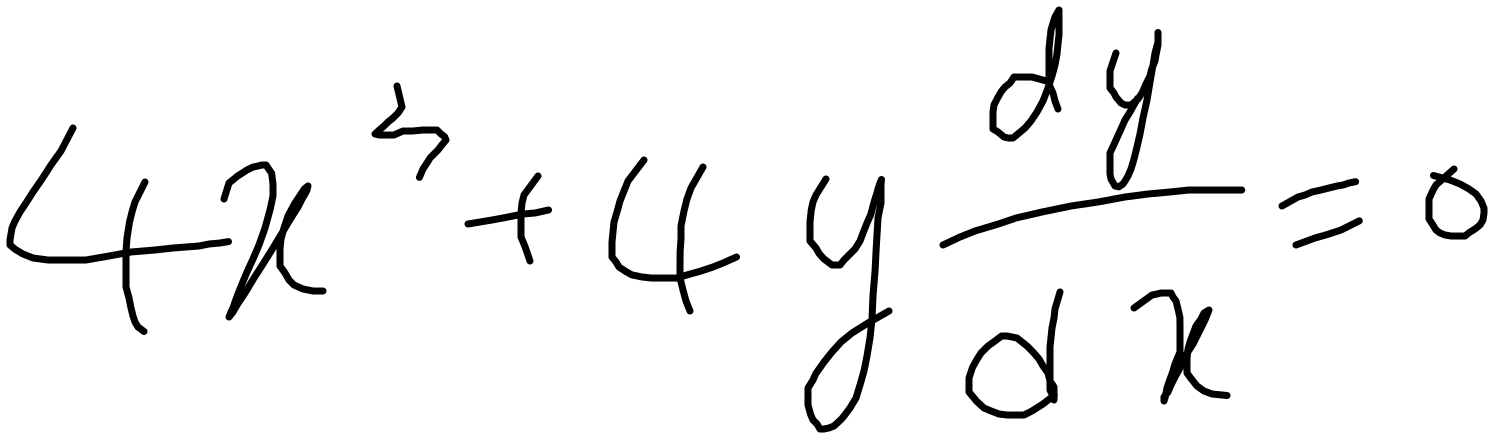

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['image_path'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

4x^{3}+4y\frac{dy}{dx}=0


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=1000,
)

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipython-input-22-152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

In [ ]:
pixel_values = processor(Image.open(test_dataset.root_dir + test_df['image_path'][0]).convert("RGB"), return_tensors="pt").pixel_values

In [ ]:
test_df = pd.read_json('rendered_images/test_labels.json')

In [ ]:
test_dataset = MathWritingDataset(root_dir='',
                           df=test_df,
                           processor=processor)

In [ ]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [ ]:
generated_ids = model.generate(pixel_values.to('cuda'))
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

\_{\\\{\\


In [ ]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
batch = next(iter(test_dataloader))

In [ ]:
!pip install "jiwer<4.0.0"


In [ ]:
from tqdm.notebook import tqdm

print("Running evaluation...")

for batch in tqdm(test_dataloader):
    # predict using generate
    pixel_values = batch["pixel_values"].to('cuda')
    outputs = model.generate(pixel_values)

    # decode
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    labels = batch["labels"]
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)

    # add batch to metric
    cer_metric.add_batch(predictions=pred_str, references=label_str)

final_score = cer_metric.compute()

In [ ]:
!gdown https://drive.google.com/uc?id=18ukM1eWK2R9Dike0xP-Guhbm4tn1I8gj
!tar zxf rendered_images.tgz
!ls rendered_images

!rm -rf rendered_images.tgz

Downloading...
From (original): https://drive.google.com/uc?id=18ukM1eWK2R9Dike0xP-Guhbm4tn1I8gj
From (redirected): https://drive.google.com/uc?id=18ukM1eWK2R9Dike0xP-Guhbm4tn1I8gj&confirm=t&uuid=505d8a46-b689-41e0-8ea3-27c09bb9b589
To: /content/rendered_images.tgz
100% 6.71G/6.71G [01:14<00:00, 90.3MB/s]
test  test_labels.json	train  train_labels.json  valid  valid_labels.json
